In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import logging
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS
from torch_sparse import spspmm, spmm, transpose, coalesce
from src.verify import check_MC
from src.utils import same_seed, sample_mask, logits2prob, create_mask, extend_mask_coo, symbasis, print_counter_MC, kron_X_I
from src.nonconvex import create_loss_fn
from src.search import create_search_proj_fn, create_search_loss_fn, search
torch.set_printoptions(precision=4)

In [2]:
time_str = time.strftime("%Y%m%d-%H%M%S")
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

In [3]:
def plot_loss(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss    = [loss[0] for loss in losses]
    diff    = [loss[1] for loss in losses]
    grad_X  = [loss[2] for loss in losses]
    hess_X  = [loss[3] for loss in losses]
    f_X     = [loss[4] for loss in losses]
    f_Z     = [loss[5] for loss in losses]
    trans   = [loss[6] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(f_X, label=r'f(X)')
    ax[2][1].plot(f_Z, label=r'f(Z)')

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(Z)-f(X)$", fontsize=30)
    ax[0][1].set_title(r"$f(Z)-f(X)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|XX^T-ZZ^T\|_F$", fontsize=30)
    ax[1][1].set_title(r"$-\|XX^T-ZZ^T\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    # ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel("Function Value", fontsize=30)
    ax[2][1].set_title("Function Value vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].legend(loc='best')
    ax[2][1].grid()

In [4]:
def compute_X_Z_e(
    variables, 
    top_k, 
    n, 
    r, 
    mu, 
    e_norm, 
    loss_type   = 'MC_max', 
    optim       = 'Adam', 
    iters       = 100, 
    lr          = 0.001, 
    min_lr      = 5e-5, 
    lr_sched    = 'cosine', 
    T           = 1, 
    trans_bound = (-1e-2, -1e2),
    M_type      = 'STE',
):
    parameters = {}
    for name, val  in variables.items():
        if name == 'X':
            X = torch.normal(0.0, torch.ones((n, r))).to(torch.float64).requires_grad_()
            parameters['X'] = X
        elif name == 'Z':
            if val is None:
                Z = torch.normal(0.0, torch.ones((n, r))).to(torch.float64).requires_grad_()
                parameters['Z'] = Z
            else:
                Z = val
        elif name == 'e':
            if val is None:
                e = torch.zeros((n, n), requires_grad=True, dtype=torch.float64)
                parameters['e'] = e
            else:
                e = val
        elif name == 'M':
            M = val
    # check whether we need to train the mask
    P = torch.rand(n*n, dtype=torch.float64)
    if top_k > 0:
        P.requires_grad_()
        parameters['P'] = P
    
    loss_fn = create_loss_fn(
        'MC_PSD', 
        P       = P.detach(),
        Z       = Z.detach(),
        e       = e.detach(),
        top_k   = top_k,
        M_type  = M_type,
        M       = M.detach(),
        sym     = symbasis(n),
        diff    = True
    )
    criterion = create_search_loss_fn(
        loss_fn, 
        loss_type, 
        P = P.detach(),
        Z = Z.detach(),
        e = e.detach(),
    )
    proj_fn = create_search_proj_fn(
        'MC', 
        mu = mu, 
        max_norm = e_norm
    )
    proj_fn(**parameters)
    losses = search(
        parameters,
        criterion,
        proj_fn,
        optim,
        iters,
        lr,
        min_lr,
        lr_sched,
        T,
        trans_bound,
    )
    
    return parameters, losses
    

/opt/homebrew/lib/python3.11/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  C = torch.sparse.mm(A, B)


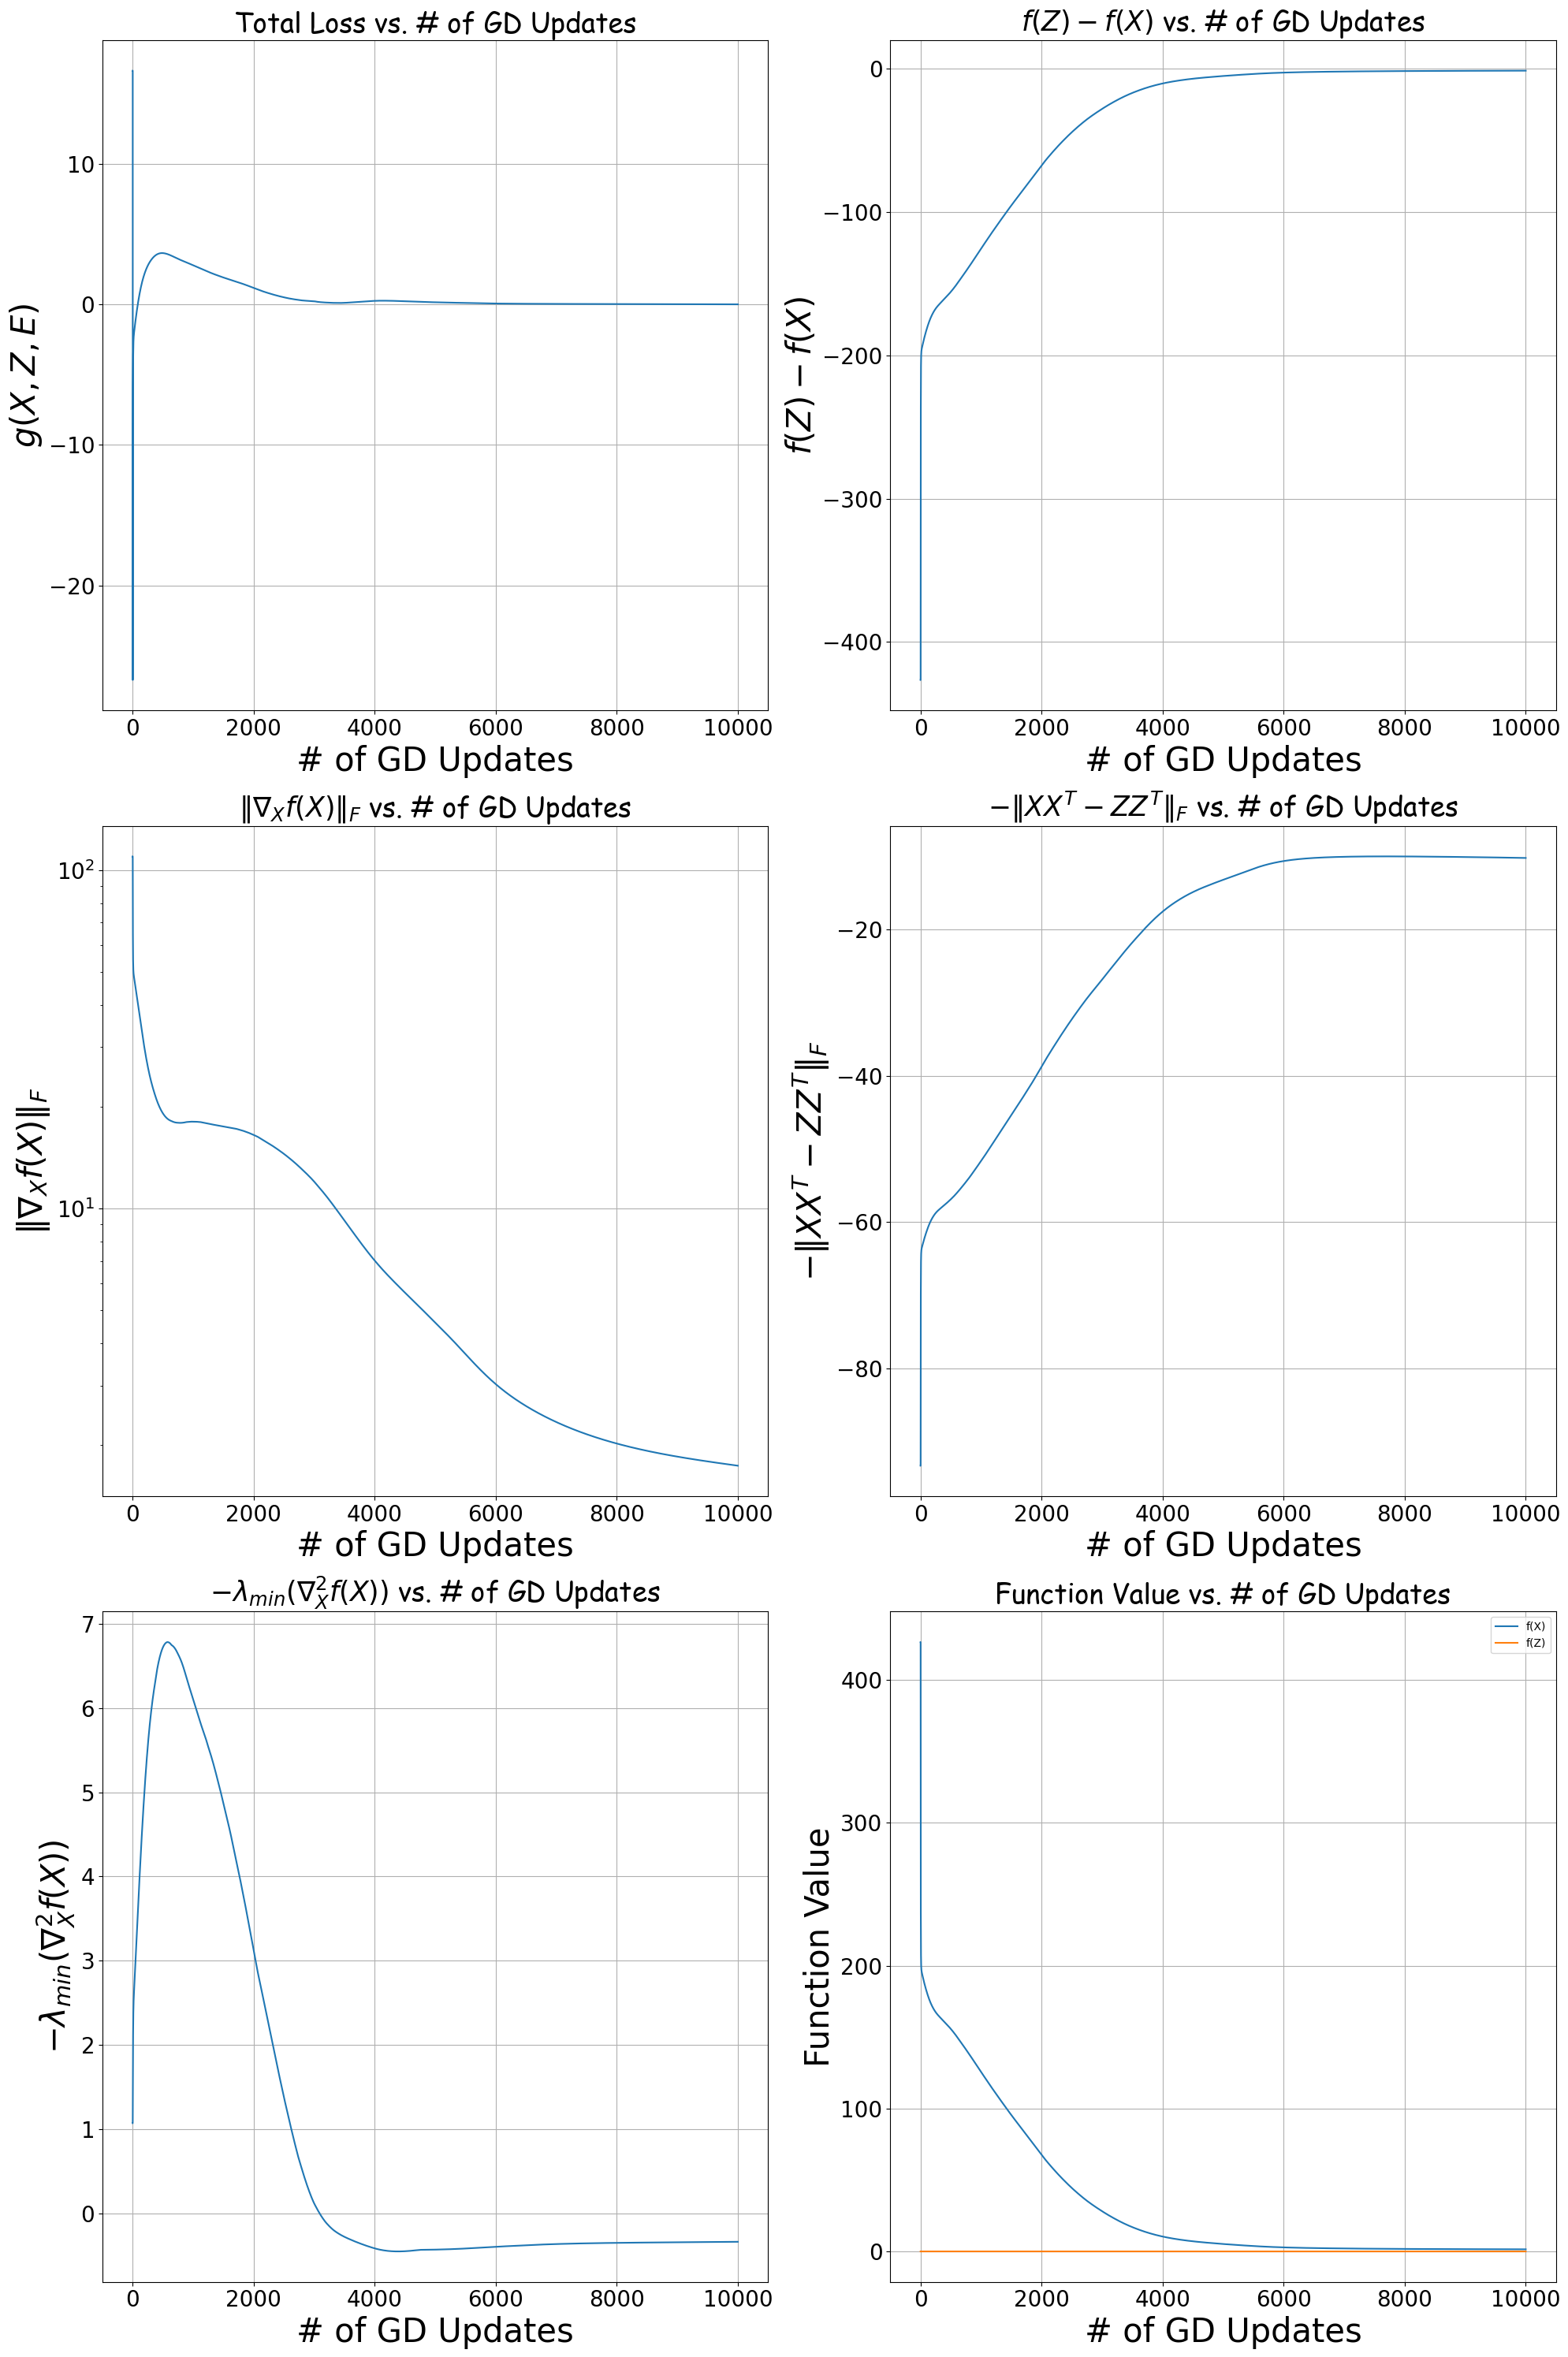

In [4]:
######## Search for (X, Z) ########
n           = 100
r           = 1
p           = 0.2
mu          = 2   # [1, n/r]
e_norm      = 1e-9
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e4)
top_k       = int(n * n * p)
M_type      = 'STE'

same_seed(34)
M = create_mask(
    # torch.tensor(sample_mask(n, n, p), dtype=torch.float64).to_sparse_coo(), 
    logits2prob(torch.rand((n*n), dtype=torch.float64), 'STE'),
    top_k, 
    'STE', 
    torch.sparse_coo_tensor(torch.tensor([[],[]]), torch.tensor([]), (n*n, n*n))
)
top_k = top_k - len(M.values())
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "M": M,
}
parameters, losses = compute_X_Z_e(
    variables,
    top_k,
    n, 
    r,  
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound
)
print_counter_MC("Search for (X, Z)", top_k, parameters, losses, M=M, M_type=M_type)
plot_loss(losses)

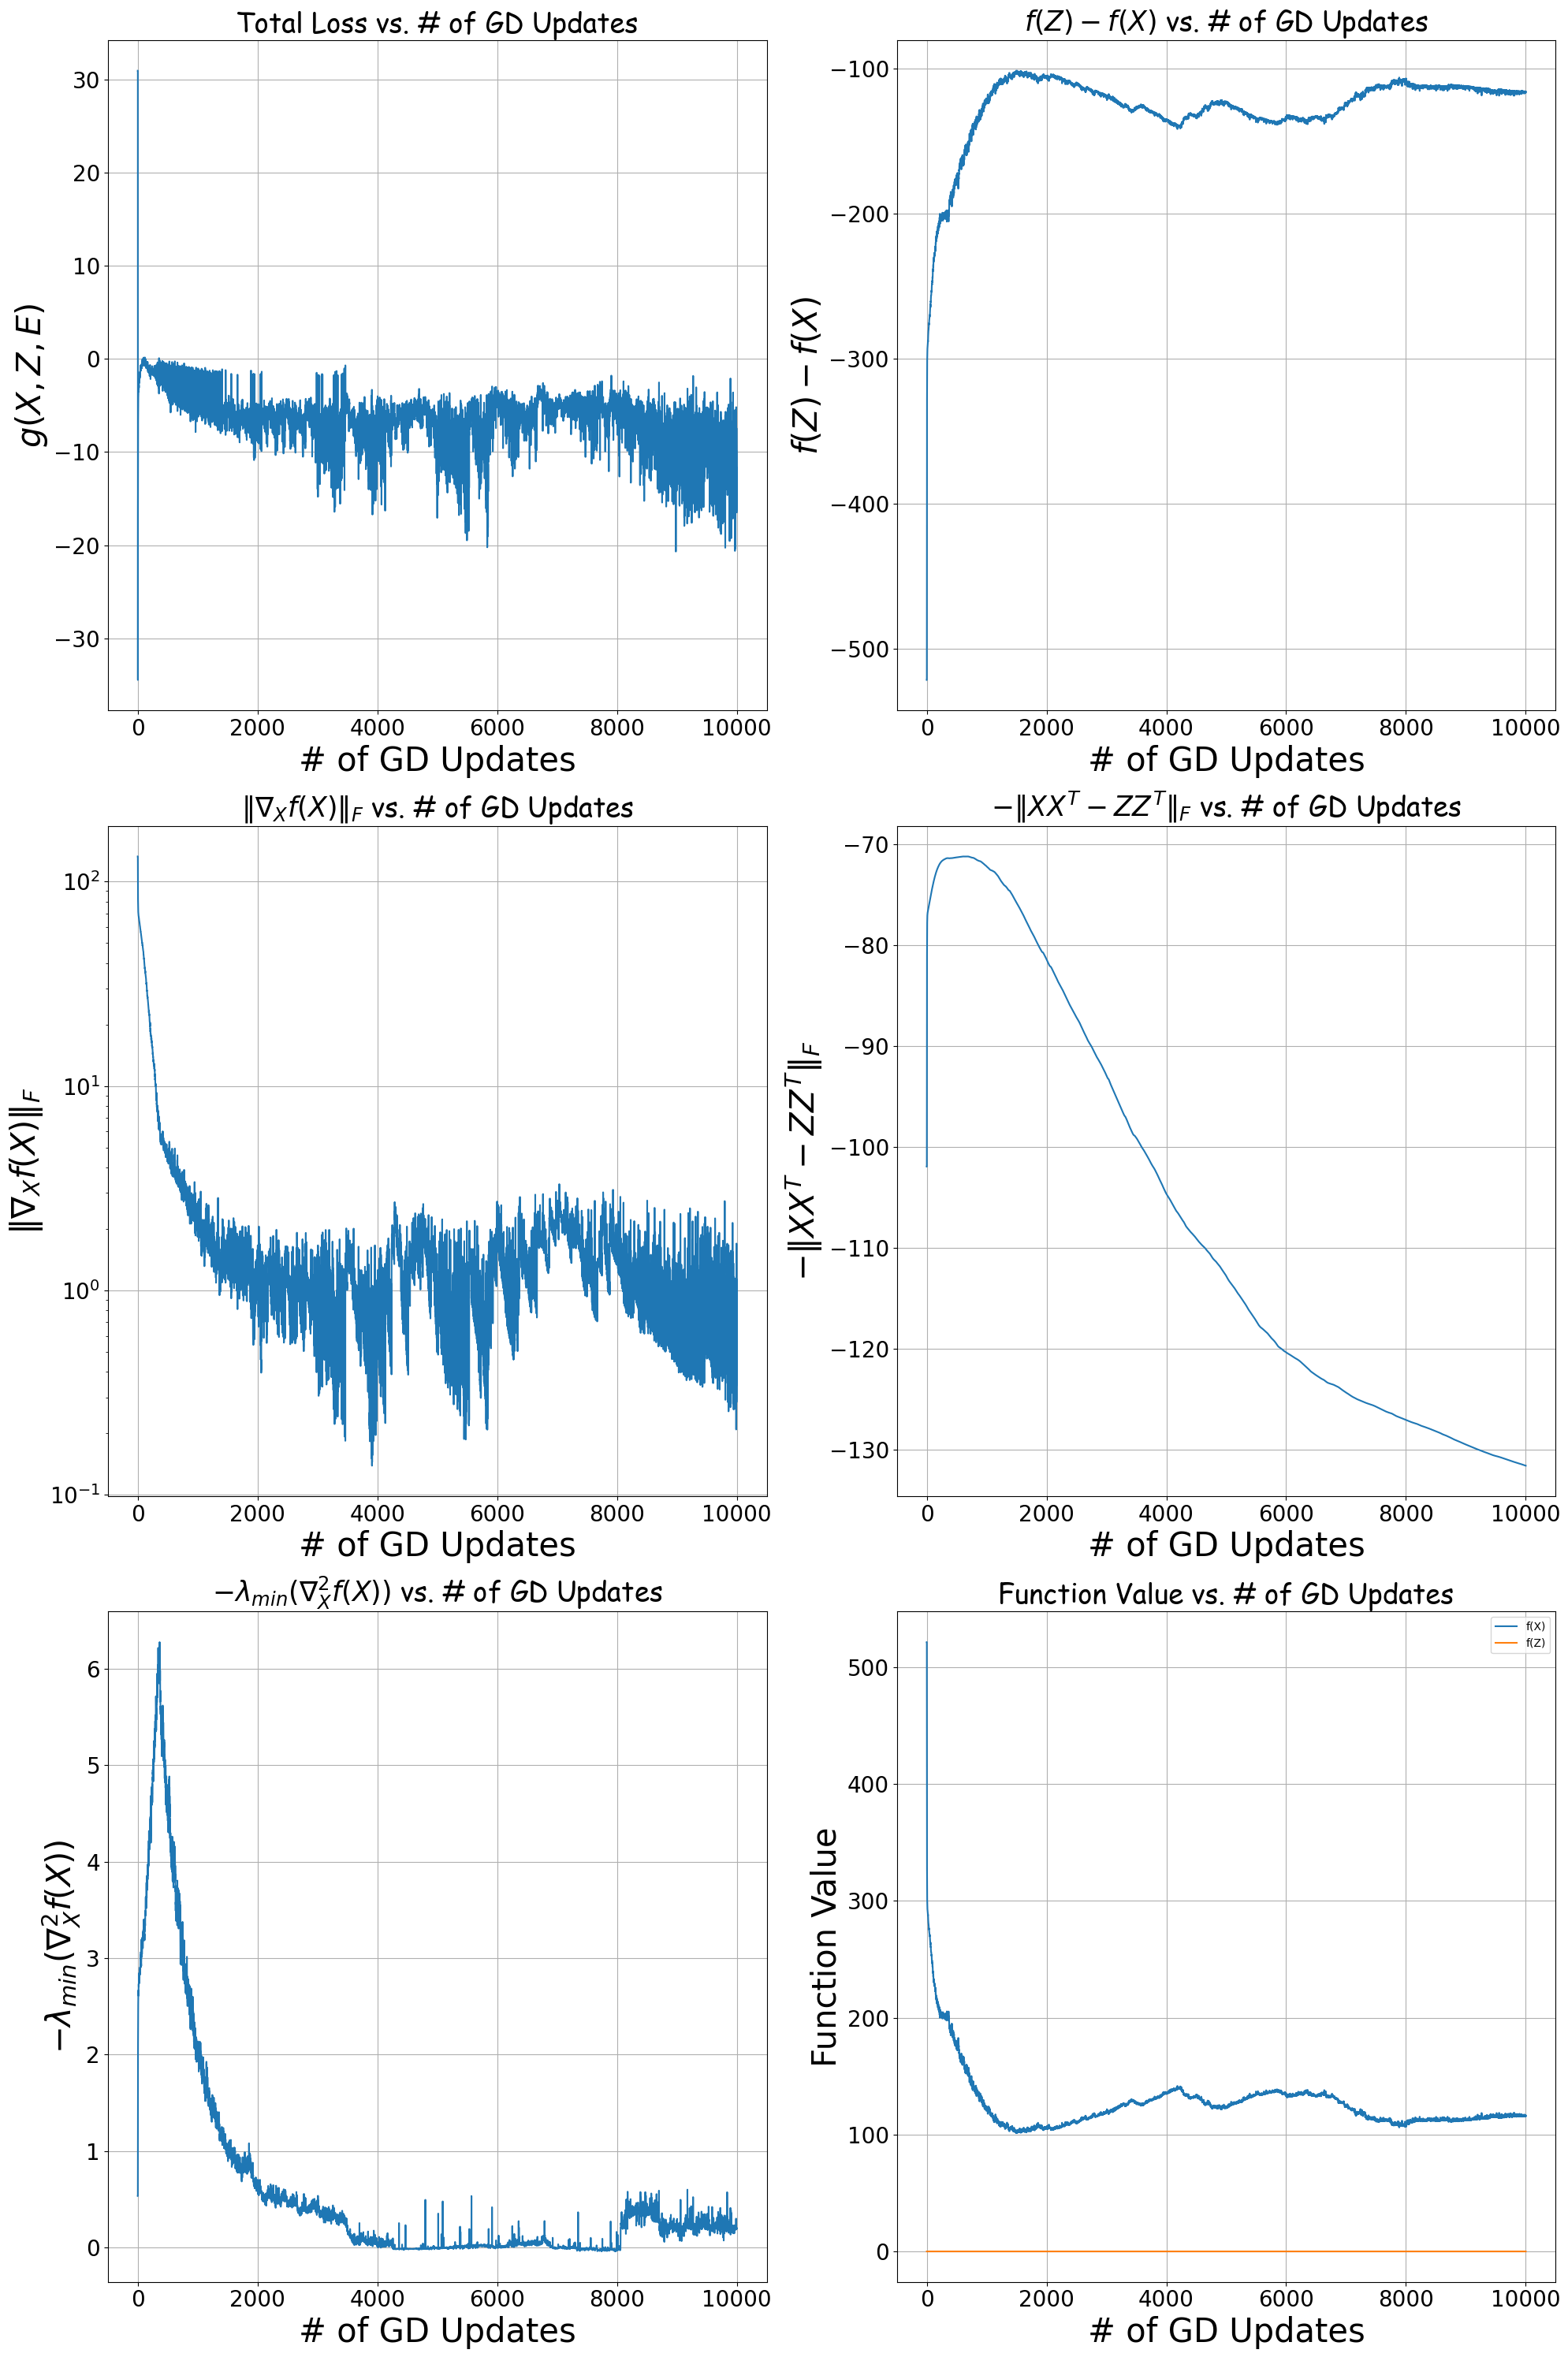

In [6]:
######## Search for (X, Z, P) ########
n           = 100
r           = 1
p           = 0.2
mu          = 2   # [1, n/r]
e_norm      = 1e-9
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e3)
top_k       = int(n * n * p)
M_type      = 'STE'

same_seed(0)
M = torch.sparse_coo_tensor(torch.tensor([[],[]]), torch.tensor([], dtype=torch.float64), (n*n, n*n))
top_k = top_k - len(M.values())
# M = torch.zeros((n, n)).to(torch.float64)
# top_k = int(top_k - torch.sum(M == 1).item())
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "M": M,
}
parameters, losses = compute_X_Z_e(
    variables,
    top_k,
    n, 
    r,  
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound,
    M_type,
)

# print_counter_MC("Search for (X, Z)", top_k, parameters, losses, M=M, M_type=M_type)
plot_loss(losses)

In [5]:
def DSE(
    top_k, 
    search_loops, 
    n, 
    r, 
    mu, 
    e_norm,  
    loss_type   = 'A', 
    optim       = 'Adam', 
    iters       = 100, 
    lr          = 0.001, 
    min_lr      = 5e-5, 
    lr_sched    = 'cosine', 
    T           = 1, 
    trans_bound = (-1e-1, -1e2),
    seed        = 0,
    M_type      = 'STE',
    M           = None,         # COO
):
    same_seed(seed)
    for i in range(search_loops):
        if M is None:
            mask = create_mask(
                logits2prob(torch.rand((n*n), dtype=torch.float64), 'STE'),
                top_k, 
                'STE', 
                torch.sparse_coo_tensor(torch.tensor([[],[]]), torch.tensor([]), (n*n, n*n))
            )
        else:
            mask = M
        variables = {
            "X": None,
            "Z": None,
            "e": None,
            "M": mask,
        }
        _top_k = top_k - len(mask.values())
        parameters, losses = compute_X_Z_e(
            variables,
            _top_k,
            n, 
            r,  
            mu,
            e_norm, 
            loss_type, 
            optim, 
            iters, 
            lr, 
            min_lr,
            lr_sched,
            T,
            trans_bound,
            M_type
        ) 
        if len(losses) < iters + 1: # Early Stop
            continue
        # print_counter_MC(f"Search Loop {i}", _top_k, parameters, losses, M=mask, M_type=M_type)
        flag, categories = check_MC(
            parameters,
            _top_k,
            mu, 
            PSD     = True,
            M       = mask,
            M_type  = M_type,
            verbose = True
        )
        if flag:
            logging.info(categories)
        

In [6]:
n           = 10
r           = 1
p           = 0.5
mu          = 2   # [1, n/r]
e_norm      = 1e-18
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.2
trans_bound = (-1e-1, -1e2)
sear_loops  = 10
top_k       = int(n * n * p)
M           = None # torch.zeros((n, n))
seed        = 0
M_type      = 'STE'

DSE(
    top_k,
    sear_loops, 
    n, 
    r, 
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr, 
    lr_sched, 
    T, 
    trans_bound,
    seed, 
    M_type,
    M,
)

/opt/homebrew/lib/python3.11/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  C = torch.sparse.mm(A, B)


Distance to Ground Truth (Convex) = 0.4532966852932293


2025-09-07 10:31:20,689: INFO: {'X': tensor([[ 0.8532],                            
        [ 0.9202],
        [ 0.9798],
        [-0.0070],
        [ 0.5492],
        [-0.1835],
        [ 0.9798],
        [-0.6718],
        [-0.4424],
        [ 0.5684]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:31:20,690: INFO: tensor([[ 7.2790e-01,  7.8509e-01,  8.3596e-01, -5.9462e-03,  4.6853e-01,
         -1.5653e-01,  8.3596e-01, -5.7320e-01, -3.7745e-01,  4.8498e-01],
        [ 7.8509e-01,  8.4677e-01,  9.0164e-01, -6.4134e-03,  5.0534e-01,
         -1.6883e-01,  9.0164e-01, -6.1824e-01, -4.0710e-01,  5.2308e-01],
        [ 8.3596e-01,  9.0164e-01,  9.6006e-01, -6.8289e-03,  5.3808e-01,
         -1.7977e-01,  9.6006e-01, -6.5830e-01, -4.3348e-01,  5.5697e-01],
        [-5.9462e-03, -6.4134e-03, -6.8289e-03,  4.8574e-05, -3.8274e-03,
          1.2787e-03, -6.8289e-03,  4.6824e-03,  3.0833e-03, -3.9617e-03],
        [ 4.6853e-01,  5.0534e-01,  5.3808e-01, -3.8274e-03,  3.0158e-01,
 

Distance to Ground Truth (Convex) = 0.818986679909731


2025-09-07 10:31:42,569: INFO: {'X': tensor([[ 0.7695],                            
        [ 0.3461],
        [-0.7064],
        [ 0.7192],
        [ 0.7429],
        [-0.0166],
        [-0.0221],
        [ 0.4661],
        [-0.6026],
        [ 0.3157]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:31:42,570: INFO: tensor([[ 5.9217e-01,  2.6636e-01, -5.4363e-01,  5.5342e-01,  5.7165e-01,
         -1.2765e-02, -1.6985e-02,  3.5867e-01, -4.6371e-01,  2.4292e-01],
        [ 2.6636e-01,  1.1981e-01, -2.4453e-01,  2.4893e-01,  2.5713e-01,
         -5.7418e-03, -7.6400e-03,  1.6133e-01, -2.0858e-01,  1.0927e-01],
        [-5.4363e-01, -2.4453e-01,  4.9906e-01, -5.0805e-01, -5.2479e-01,
          1.1719e-02,  1.5593e-02, -3.2927e-01,  4.2570e-01, -2.2301e-01],
        [ 5.5342e-01,  2.4893e-01, -5.0805e-01,  5.1720e-01,  5.3424e-01,
         -1.1930e-02, -1.5874e-02,  3.3520e-01, -4.3336e-01,  2.2703e-01],
        [ 5.7165e-01,  2.5713e-01, -5.2479e-01,  5.3424e-01,  5.5185e-01,
 

Distance to Ground Truth (Convex) = 1.1872437218602492


2025-09-07 10:32:03,531: INFO: {'X': tensor([[-0.5284],                             
        [-0.3665],
        [-0.5173],
        [ 0.8570],
        [ 0.7612],
        [ 0.0121],
        [-0.8624],
        [ 0.1551],
        [-0.8655],
        [ 0.4835]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:32:03,531: INFO: tensor([[ 2.7918e-01,  1.9363e-01,  2.7334e-01, -4.5281e-01, -4.0221e-01,
         -6.3785e-03,  4.5570e-01, -8.1948e-02,  4.5734e-01, -2.5546e-01],
        [ 1.9363e-01,  1.3429e-01,  1.8958e-01, -3.1404e-01, -2.7895e-01,
         -4.4238e-03,  3.1605e-01, -5.6835e-02,  3.1719e-01, -1.7717e-01],
        [ 2.7334e-01,  1.8958e-01,  2.6763e-01, -4.4333e-01, -3.9379e-01,
         -6.2451e-03,  4.4617e-01, -8.0234e-02,  4.4777e-01, -2.5012e-01],
        [-4.5281e-01, -3.1404e-01, -4.4333e-01,  7.3440e-01,  6.5233e-01,
          1.0345e-02, -7.3909e-01,  1.3291e-01, -7.4175e-01,  4.1433e-01],
        [-4.0221e-01, -2.7895e-01, -3.9379e-01,  6.5233e-01,  5.7943e-01,


Distance to Ground Truth (Convex) = 0.0022160749372673533


2025-09-07 10:32:24,881: INFO: {'X': tensor([[-0.8764],                            
        [ 1.0766],
        [ 0.4392],
        [-0.7909],
        [-0.2799],
        [ 0.5120],
        [-0.9034],
        [ 0.6057],
        [ 1.0159],
        [ 0.7458]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:32:24,881: INFO: tensor([[ 0.7680, -0.9435, -0.3849,  0.6931,  0.2453, -0.4487,  0.7917, -0.5308,
         -0.8903, -0.6536],
        [-0.9435,  1.1591,  0.4728, -0.8515, -0.3013,  0.5513, -0.9726,  0.6521,
          1.0938,  0.8029],
        [-0.3849,  0.4728,  0.1929, -0.3473, -0.1229,  0.2249, -0.3967,  0.2660,
          0.4462,  0.3275],
        [ 0.6931, -0.8515, -0.3473,  0.6256,  0.2214, -0.4050,  0.7145, -0.4791,
         -0.8035, -0.5898],
        [ 0.2453, -0.3013, -0.1229,  0.2214,  0.0783, -0.1433,  0.2528, -0.1695,
         -0.2843, -0.2087],
        [-0.4487,  0.5513,  0.2249, -0.4050, -0.1433,  0.2622, -0.4626,  0.3102,
          0.5202,  0.3819],
        [ 0.7917,

Distance to Ground Truth (Convex) = 1.668375217906571


2025-09-07 10:32:46,061: INFO: {'X': tensor([[ 0.2374],                             
        [-0.7518],
        [ 0.7364],
        [ 0.0419],
        [ 0.7589],
        [-0.3196],
        [-0.7591],
        [-0.0993],
        [-0.3323],
        [ 0.5837]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:32:46,062: INFO: tensor([[ 0.0564, -0.1785,  0.1748,  0.0099,  0.1802, -0.0759, -0.1802, -0.0236,
         -0.0789,  0.1386],
        [-0.1785,  0.5652, -0.5536, -0.0315, -0.5706,  0.2403,  0.5707,  0.0747,
          0.2498, -0.4388],
        [ 0.1748, -0.5536,  0.5423,  0.0309,  0.5589, -0.2354, -0.5590, -0.0731,
         -0.2447,  0.4298],
        [ 0.0099, -0.0315,  0.0309,  0.0018,  0.0318, -0.0134, -0.0318, -0.0042,
         -0.0139,  0.0245],
        [ 0.1802, -0.5706,  0.5589,  0.0318,  0.5760, -0.2426, -0.5761, -0.0754,
         -0.2522,  0.4430],
        [-0.0759,  0.2403, -0.2354, -0.0134, -0.2426,  0.1021,  0.2426,  0.0317,
          0.1062, -0.1866],
        [-0.1802

Distance to Ground Truth (Convex) = 1.3694849342004875e-07


2025-09-07 10:33:07,402: INFO: {'X': tensor([[ 0.3568],                             
        [ 0.0235],
        [ 0.9195],
        [-0.8916],
        [-0.0545],
        [-0.4357],
        [ 0.4030],
        [-0.9195],
        [-0.8419],
        [-0.7415]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:33:07,402: INFO: tensor([[ 1.2733e-01,  8.4008e-03,  3.2812e-01, -3.1814e-01, -1.9442e-02,
         -1.5548e-01,  1.4379e-01, -3.2812e-01, -3.0043e-01, -2.6460e-01],
        [ 8.4008e-03,  5.5426e-04,  2.1649e-02, -2.0990e-02, -1.2827e-03,
         -1.0258e-02,  9.4869e-03, -2.1649e-02, -1.9822e-02, -1.7457e-02],
        [ 3.2812e-01,  2.1649e-02,  8.4556e-01, -8.1983e-01, -5.0100e-02,
         -4.0067e-01,  3.7054e-01, -8.4556e-01, -7.7420e-01, -6.8185e-01],
        [-3.1814e-01, -2.0990e-02, -8.1983e-01,  7.9488e-01,  4.8576e-02,
          3.8848e-01, -3.5927e-01,  8.1983e-01,  7.5064e-01,  6.6110e-01],
        [-1.9442e-02, -1.2827e-03, -5.0100e-02,  4.8576e-02,  2.9685e-03,


Distance to Ground Truth (Convex) = 6.057493389822036e-09


2025-09-07 10:35:29,949: INFO: {'X': tensor([[-1.1613],                            
        [-0.7269],
        [ 0.3740],
        [ 1.1399],
        [-0.2136],
        [-1.1287],
        [ 0.2680],
        [ 1.2028],
        [ 0.1594],
        [ 1.0265]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:35:29,949: INFO: tensor([[ 1.3487,  0.8442, -0.4343, -1.3237,  0.2481,  1.3108, -0.3112, -1.3968,
         -0.1851, -1.1921],
        [ 0.8442,  0.5284, -0.2718, -0.8286,  0.1553,  0.8205, -0.1948, -0.8743,
         -0.1159, -0.7462],
        [-0.4343, -0.2718,  0.1399,  0.4263, -0.0799, -0.4221,  0.1002,  0.4498,
          0.0596,  0.3839],
        [-1.3237, -0.8286,  0.4263,  1.2993, -0.2435, -1.2866,  0.3055,  1.3710,
          0.1817,  1.1701],
        [ 0.2481,  0.1553, -0.0799, -0.2435,  0.0456,  0.2411, -0.0573, -0.2570,
         -0.0341, -0.2193],
        [ 1.3108,  0.8205, -0.4221, -1.2866,  0.2411,  1.2740, -0.3025, -1.3576,
         -0.1799, -1.1587],
        [-0.3112,

Distance to Ground Truth (Convex) = 1.2914945488754304e-09


2025-09-07 10:38:32,691: INFO: {'X': tensor([[-7.3068e-01],                        
        [ 1.1148e+00],
        [ 5.8514e-01],
        [-3.9281e-04],
        [ 1.0395e+00],
        [-2.0725e-01],
        [ 7.0663e-01],
        [ 8.2681e-01],
        [ 8.2255e-01],
        [-1.0544e+00]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:38:32,691: INFO: tensor([[ 5.3389e-01, -8.1456e-01, -4.2755e-01,  2.8702e-04, -7.5955e-01,
          1.5143e-01, -5.1632e-01, -6.0413e-01, -6.0101e-01,  7.7042e-01],
        [-8.1456e-01,  1.2428e+00,  6.5231e-01, -4.3790e-04,  1.1589e+00,
         -2.3104e-01,  7.8775e-01,  9.2173e-01,  9.1697e-01, -1.1754e+00],
        [-4.2755e-01,  6.5231e-01,  3.4239e-01, -2.2985e-04,  6.0826e-01,
         -1.2127e-01,  4.1348e-01,  4.8380e-01,  4.8130e-01, -6.1696e-01],
        [ 2.8702e-04, -4.3790e-04, -2.2985e-04,  1.5430e-07, -4.0834e-04,
          8.1408e-05, -2.7757e-04, -3.2478e-04, -3.2310e-04,  4.1418e-04],
        [-7.5955e-01,  1.1589e+00,  6.0

Distance to Ground Truth (Convex) = 0.7601244401220698


2025-09-07 10:41:17,607: INFO: {'X': tensor([[ 1.6448e-06],                        
        [ 8.6834e-01],
        [ 5.5502e-01],
        [ 5.3949e-01],
        [ 6.9039e-01],
        [ 8.6009e-01],
        [-3.4279e-02],
        [-6.6736e-01],
        [ 4.4573e-04],
        [-8.6834e-01]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:41:17,607: INFO: tensor([[ 2.7054e-12,  1.4283e-06,  9.1290e-07,  8.8737e-07,  1.1356e-06,
          1.4147e-06, -5.6382e-08, -1.0977e-06,  7.3314e-10, -1.4283e-06],
        [ 1.4283e-06,  7.5401e-01,  4.8194e-01,  4.6846e-01,  5.9949e-01,
          7.4685e-01, -2.9766e-02, -5.7949e-01,  3.8705e-04, -7.5401e-01],
        [ 9.1290e-07,  4.8194e-01,  3.0804e-01,  2.9943e-01,  3.8318e-01,
          4.7736e-01, -1.9025e-02, -3.7039e-01,  2.4739e-04, -4.8194e-01],
        [ 8.8737e-07,  4.6846e-01,  2.9943e-01,  2.9105e-01,  3.7246e-01,
          4.6402e-01, -1.8493e-02, -3.6004e-01,  2.4047e-04, -4.6846e-01],
        [ 1.1356e-06,  5.9949e-01,  3.8

Distance to Ground Truth (Convex) = 0.15493336817940206


2025-09-07 10:41:42,176: INFO: {'X': tensor([[-0.5196],                            
        [ 0.0860],
        [-0.1050],
        [-0.5843],
        [ 0.5854],
        [ 0.1861],
        [-0.5093],
        [ 0.3691],
        [ 0.6838],
        [-0.6838]], dtype=torch.float64, requires_grad=True)}
2025-09-07 10:41:42,177: INFO: tensor([[ 0.2699, -0.0447,  0.0545,  0.3036, -0.3041, -0.0967,  0.2646, -0.1918,
         -0.3553,  0.3553],
        [-0.0447,  0.0074, -0.0090, -0.0503,  0.0504,  0.0160, -0.0438,  0.0318,
          0.0588, -0.0588],
        [ 0.0545, -0.0090,  0.0110,  0.0613, -0.0615, -0.0195,  0.0535, -0.0388,
         -0.0718,  0.0718],
        [ 0.3036, -0.0503,  0.0613,  0.3414, -0.3421, -0.1088,  0.2976, -0.2157,
         -0.3996,  0.3996],
        [-0.3041,  0.0504, -0.0615, -0.3421,  0.3427,  0.1090, -0.2981,  0.2161,
          0.4003, -0.4003],
        [-0.0967,  0.0160, -0.0195, -0.1088,  0.1090,  0.0346, -0.0948,  0.0687,
          0.1273, -0.1273],
        [ 0.2646,

In [13]:
M = torch.tensor([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0]
], dtype=torch.float32)
M_vec = torch.sparse_coo_tensor(
    torch.stack([torch.arange(9), torch.arange(9)]),
    M.view(-1),
    (9, 9)
).coalesce()
Ps = symbasis(3)
def f(X, Z):
    r = M * (X @ X.T - Z @ Z.T)
    return 0.25 * r.square().sum()
def grad_X(X, Z):
    A_idx, A_val = M_vec.indices(), M_vec.values()
    r = (X @ X.T - Z @ Z.T).view(-1, 1).to_sparse_coo()
    print(r.indices(), r.values())
    Ar_idx, Ar_val = spspmm(A_idx, A_val, r.indices(), r.values(), 9, 9, 1)
    print(Ar_val)
    AT_idx, AT_val = transpose(A_idx, A_val, 9, 9)
    Ps_idx, Ps_val = coalesce(Ps.indices(), Ps.values(), 9, 9)
    Ps_AT_idx, Ps_AT_val = spspmm(Ps_idx, Ps_val, AT_idx, AT_val, 9, 9, 9)
    # Ps_AT = torch.sparse_coo_tensor(Ps_AT_idx, Ps_AT_val, (9, 9)).coalesce()
    XT_I = kron_X_I(X.T, 3)
    print(XT_I)
    # XT_I_idx, XT_I_val = coalesce(XT_I_idx, XT_I_val, 3, 9)
    # JxT_AT = torch.sparse.mm(XT_I, Ps_AT)
    Ps_ATAr_idx, Ps_ATAr_val = spspmm(Ps_AT_idx, Ps_AT_val, Ar_idx, Ar_val, 9, 9, 1)
    print(Ps_AT_val)
    # JxT_AT_idx, JxT_AT_val = spspmm(XT_I.indices(), XT_I.values(), Ps_AT.indices(), Ps_AT.values(), 3, 9, 9)
    gradient_idx, gradient_val = spspmm(XT_I.indices(), XT_I.values(), Ps_ATAr_idx, Ps_ATAr_val, 3, 9, 1)
    print(gradient_val)
    return gradient_val
      
same_seed(0)
x = torch.randn(3, 1, requires_grad=True)
z = torch.randn(3, 1, requires_grad=True)
f_X = f(x, z)
gradient1 = grad_X(x, z)
# gradient2 = grad(f(x, z), x, create_graph=True)[0]
first_order_loss1 = torch.linalg.norm(gradient1)
first_order_loss1.backward()
# first_order_loss2 = torch.linalg.norm(gradient2)
# first_order_loss2.backward()
print(f_X)
print(gradient1)
# print(gradient2)
print(x.grad)

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]]) tensor([ 2.0516,  0.1643, -2.5625,  0.1643, -1.0901, -0.8775, -2.5625, -0.8775,
         2.7911], grad_fn=<ValuesBackward0>)
tensor([ 0.0000,  0.1643,  0.0000,  0.0000,  0.0000, -0.8775, -2.5625,  0.0000,
         0.0000])
tensor(indices=tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
                       [0, 3, 6, 1, 4, 7, 2, 5, 8]]),
       values=tensor([ 1.5410, -0.2934, -2.1788,  1.5410, -0.2934, -2.1788,
                       1.5410, -0.2934, -2.1788]),
       size=(3, 9), nnz=9, layout=torch.sparse_coo, grad_fn=<ToSparseBackward1>)
tensor([0.0000, 0.5000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.5000,
        0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000])
tensor([ 2.7675,  1.0825, -1.8457])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [15]:
A = torch.sparse_coo_tensor(
    torch.stack([torch.arange(9), torch.arange(9)]),
    torch.randn(9, requires_grad=True),
    (9, 9)
).coalesce()
B = torch.sparse_coo_tensor(
    torch.stack([torch.arange(9), torch.arange(9)]),
    torch.randn(9, requires_grad=True),
    (9, 9)
).coalesce()
C_idx, C_val = spspmm(A.indices(), A.values(), B.indices(), B.values(), 9, 9, 9)
print(C_idx, C_val)

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5, 6, 7, 8]]) tensor([ 0.1041, -2.8041, -0.3342,  0.8146,  0.0105, -0.1964, -0.4762,  0.0531,
         0.0553])
